In [135]:
import os
import json
import random
import pandas as pd
import numpy as np

In [136]:
# MOS Score
test_mos = pd.read_csv(
    "/data/share/data/Speech/somos/training_files/split1/clean/test_mos_list.csv")
test_mos

,utteranceId,mean
0,LJ002-0181_110.wav,4.000000
1,LJ002-0181_148.wav,4.000000
2,LJ003-0083_177.wav,3.727273
3,LJ003-0173_007.wav,3.400000
4,LJ003-0173_166.wav,3.000000
...,...,...
2995,wiki_0096_105.wav,3.714286
2996,wiki_0097_061.wav,3.100000
2997,wiki_0098_115.wav,2.000000
2998,wiki_0098_124.wav,2.333333


In [137]:
transcripts['LJ002-0181']

"to those in other London prisons, for Newgate was not the only place of durance for these unfortunate people. There were also the King's Bench."

In [138]:
# transcript 
lines = []
# path = "/data/share/data/Speech/somos/transcript/additional_sentences.txt"
# with open(path) as f:
#     for line in f:
#         lines.append(line)
path = "/data/share/data/Speech/somos/transcript/all_sentences.txt"
with open(path) as f:
    for line in f:
        lines.append(line)
transcripts = {}
for line in lines:
    items = line.split('\t')
    assert len(items) == 2
    transcripts[items[0]] = items[1].strip()

In [139]:
len(transcripts)

2000

In [140]:
uttId0

'wiki_0099'

In [141]:
uttId

'wiki_0099_056.wav'

In [142]:
path

'/data/share/data/Speech/somos/transcript/all_sentences.txt'

In [143]:
# data 
# /data/share/data/Speech/somos/audios/{utteranceId}
data = []
for i in range(len(test_mos)):
    uttId, mos = test_mos['utteranceId'][i], test_mos['mean'][i]
    uttId0 = uttId.rsplit('_', 1)[0]
    if 'gt_' in uttId0:
        uttId0 = uttId0.replace('gt_', '')
    path = f"/data/share/data/Speech/somos/audios/{uttId}"
    assert os.path.exists(path)
    assert uttId0 in transcripts
    data.append({
        'uttId': uttId.replace('.wav', ''),
        'mos': mos,
        'text': transcripts[uttId0],
        'path': path
    })

In [144]:
uttId0, uttId

('wiki_0099', 'wiki_0099_056.wav')

In [145]:
len(test_mos), len(data)

(3000, 3000)

In [154]:
random.choice(data)

{'uttId': 'news_2010_0135_002',
 'mos': 3.727272727272727,
 'text': 'He would have to make some sort of try.',
 'path': '/data/share/data/Speech/somos/audios/news_2010_0135_002.wav'}

# Pointwise

In [260]:
import matplotlib.pyplot as plt

In [265]:
len(data)

3000

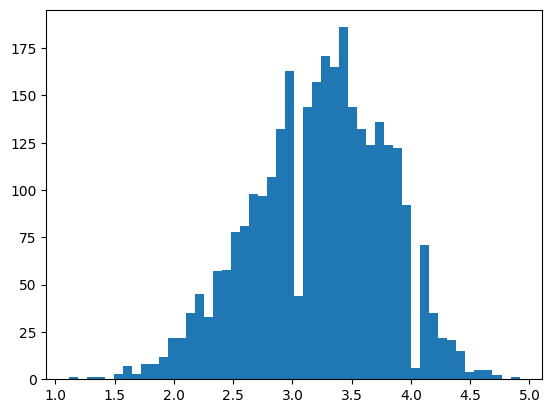

In [266]:
mos_scores = []
for x in data:
    mos_scores.append(x['mos'])
_ = plt.hist(mos_scores, bins=50)

In [267]:
len(mos_scores)

3000

In [180]:
data_pointwise450 = random.sample(data, 450)

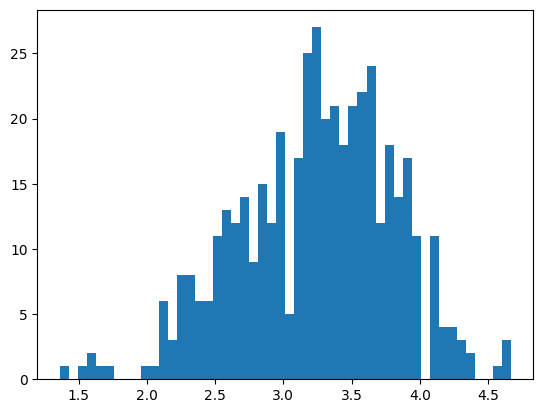

In [181]:
mos_scores = []
for x in data_pointwise450:
    mos_scores.append(x['mos'])
_ = plt.hist(mos_scores, bins=50)

In [183]:
with open("/data/workspace/ppotsawee/audioLM-as-judge/data/data_somos_pointwise450.json", "w") as f:
    json.dump(data_pointwise450, f, indent=4)

In [275]:
with open("/data/workspace/ppotsawee/audioLM-as-judge/data/data_somos_pointwise_all.json", "w") as f:
    json.dump(data, f, indent=4)

## Pointwise ICL

In [248]:
# MOS Score
train_mos = pd.read_csv(
    "/data/share/data/Speech/somos/training_files/split1/clean/train_mos_list.txt")
# train_mos

In [255]:
# train_data
# in total, all = 14100
# keep only those +- 0.1 from a full integer --> 
train_data = []
for i in range(len(train_mos)):
    uttId, mos = train_mos['utteranceId'][i], train_mos['mean'][i]

    diff = np.abs(mos - round(mos))
    if diff > 0.1:
        continue
    
    uttId0 = uttId.rsplit('_', 1)[0]
    if 'gt_' in uttId0:
        uttId0 = uttId0.replace('gt_', '')
    path = f"/data/share/data/Speech/somos/audios/{uttId}"
    assert os.path.exists(path)
    assert uttId0 in transcripts
    train_data.append({
        'uttId': uttId.replace('.wav', ''),
        'mos': mos,
        'round_mos': round(mos),
        'text': transcripts[uttId0],
        'path': path
    })

In [256]:
len(train_data)

2577

In [257]:
random.shuffle(train_data)
train_data_by_mos = {1: [], 2: [], 3: [], 4: [], 5: []}
for x in train_data:
    train_data_by_mos[x['round_mos']] += [x]

In [258]:
with open("/data/workspace/ppotsawee/audioLM-as-judge/data/data_somos_pointwise_train_round2577.json", "w") as f:
    json.dump(train_data_by_mos, f, indent=4)

# Pairwise Data Creation

In [146]:
pairwise_data0 = {}
pairwise_data = []
for x in data:
    uttId0 = x['uttId'].rsplit('_', 1)[0]
    if uttId0 not in pairwise_data0:
        pairwise_data0[uttId0] = []
    pairwise_data0[uttId0].append(x)
print("len(pairwise_data0):", len(pairwise_data0))
for uttId0, instances in pairwise_data0.items():
    N = len(instances)
    for i in range(N-1):
        for j in range(i+1, N):
            x1 = instances[i]
            x2 = instances[j]
            assert x1['uttId'] != x2['uttId']
            assert x1['text'] == x2['text']
            if x1['mos'] != x2['mos'] and np.abs(x1['mos']-x2['mos']) > 0.0:
                pairwise_data.append([x1, x2])
print("len(pairwise_data):", len(pairwise_data))

len(pairwise_data0): 1528
len(pairwise_data): 3567


In [147]:
random.choice(pairwise_data)

[{'uttId': 'reportorial_2011_0040_089',
  'mos': 2.555555555555556,
  'text': "Plaintiffs , he says , will argue that damaged structures weren't built to proper design standards .",
  'path': '/data/share/data/Speech/somos/audios/reportorial_2011_0040_089.wav'},
 {'uttId': 'reportorial_2011_0040_183',
  'mos': 3.3846153846153846,
  'text': "Plaintiffs , he says , will argue that damaged structures weren't built to proper design standards .",
  'path': '/data/share/data/Speech/somos/audios/reportorial_2011_0040_183.wav'}]

In [148]:
with open("/data/workspace/ppotsawee/audioLM-as-judge/data/data_somos_pairwise_diffall.json", "w") as f:
    json.dump(pairwise_data, f, indent=4)